In [3]:
import numpy as np

from astropy import units as u
from astropy import constants as c
from astropy.table import Table
from astropy.modeling import models, fitting
import galarp as grp

grp.pyplot_style()

from matplotlib import pyplot as plt

from gala.units import UnitSystem   

from gala import integrate as gi
from gala import dynamics as gd
from gala import potential as gp
from gala.units import galactic

In [2]:
test_host_potential = grp.builtins.JZ2023_1e14()

host_1e12 = grp.HostOrbit(potential=grp.builtins.JZ2023_1e12(), init_conditions=grp.builtins.JZ2023_1e12_IC())
host_1e13 = grp.HostOrbit(potential=grp.builtins.JZ2023_1e13(), init_conditions=grp.builtins.JZ2023_1e13_IC())


host_1e14 = grp.HostOrbit(potential=grp.builtins.JZ2023_1e14(), 
                          init_conditions=grp.builtins.JZ2023_1e14_IC(),
                          density=grp.SphericalBetaModel())


host_1e12.integrate(n_steps=100000)
host_1e13.integrate(n_steps=100000)
host_1e14.integrate(n_steps=10000)

test_satellite = grp.builtins.JZ2023_Satellite()

In [3]:
def gen_ENZO_filename(host, units = UnitSystem(u.cm, u.s, u.radian, u.g)):
    
    t = host.orbit.t.to(units['time'])

    x, y, z = host.orbit.pos.xyz
    r = np.sqrt(x**2 + y**2 + z**2)

    # Get density
    dens = host.density.evaluate(r)

    dx, dy, dz = host.orbit.vel.d_xyz
    
    temps = [host.temp.value for i in range(len(t))]

gen_ENZO_filename(host_1e14)

In [4]:
from astropy import units as u

def test_rho(r0 = 11.87 * u.kpc):
    return 1.46e-24 * (r0 / (3.07 * u.kpc))**(-2/3) * (u.g / u.cm**3)


In [5]:
coma_mass = 1.4e15 * u.Msun

coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                        c=9, 
                                        units=galactic)

vx = -1500
vy =  400
vz = -2420

vel = [vx, vy, vz] * u.km / u.s

pos = [355, 0, 0] * u.kpc


print(pos)
print(vel)

[355.   0.   0.] kpc
[-1500.   400. -2420.] km / s


In [6]:
def gen_coma_orbit(dw_angle=25):

    coma_mass = 1.4e15 * u.Msun
    concentration = 9

    coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                            c=concentration, 
                                            units=galactic)

    pos = [355, 0, 0] * u.kpc

    vrad = -2420
    vtot = vrad / np.cos(np.deg2rad(dw_angle))
    v_pos = np.sqrt(vtot**2 - vrad**2)

    vel = [v_pos, 0, vrad] * u.km / u.s

    w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

    n_steps = 1000
    dt = 5 * u.Myr

    orbits_forward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=dt, n_steps=n_steps)
    orbits_backward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=-dt, n_steps=n_steps)

    q_forward = orbits_forward.pos.xyz
    q_backward = orbits_backward.pos.xyz
    p_forward = orbits_forward.vel.d_xyz
    p_backward = orbits_backward.vel.d_xyz

    ts_forward = orbits_forward.t
    ts_backward = orbits_backward.t

    q_backward = np.flip(q_backward, axis=1)
    p_backward = np.flip(p_backward, axis=1)
    ts_backward = np.flip(ts_backward)

    q_tot = np.concatenate((q_backward, q_forward), axis=1)
    p_tot = np.concatenate((p_backward, p_forward), axis=1)
    ts_tot = np.concatenate((ts_backward, ts_forward))

    ts_tot -= np.min(ts_tot)

    return ts_tot, q_tot, p_tot

ts, qs, ps = gen_coma_orbit()


In [7]:
@models.custom_model()
def Beta_Model(x, n_0=1., r_c=1., beta=1.):
    return (n_0 * (1. + (x/r_c)**2) ** (-3.*beta/2.))



Model: Beta_Model
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
             n_0                  r_c               beta       
    ---------------------- ----------------- ------------------
    2.2693100137522132e-26 83.44855044763145 0.5415934212068201


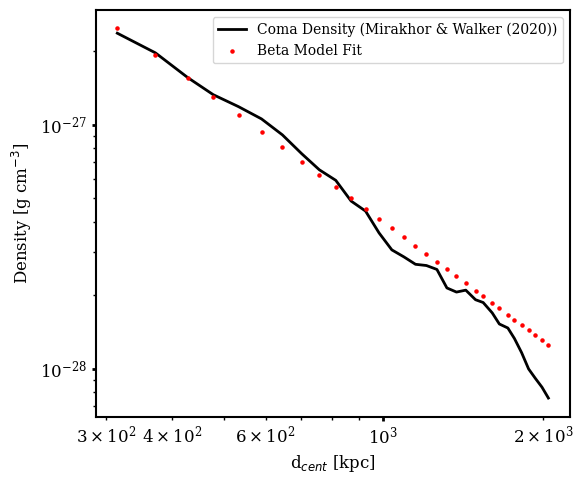

In [8]:
t_coma_density = Table.read("temp/Coma-Density.csv", format="csv")

radii, density = t_coma_density['Radius'], t_coma_density['Density']

radii *= 60 * 0.468

density *= u.cm ** -3
density *= c.m_p

density = density.to(u.g / u.cm**3)

fitter = fitting.LevMarLSQFitter()

fit = fitter(Beta_Model(n_0=1e-27, beta=0.5), radii.value, density.value)
print(fit)
plt.figure(figsize=(6,5))

plt.plot(radii, density, color="black", lw=2, label="Coma Density (Mirakhor & Walker (2020))")
plt.scatter(radii, fit(radii), color="Red", s=5, zorder=3, label="Beta Model Fit")

xlims, ylims = plt.xlim(), plt.ylim()


plt.legend(loc="upper right", fontsize=10)
plt.xlabel("d$_{cent}$ [kpc]")
plt.ylabel('Density [g cm$^{-3}$]')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.show()

In [39]:
def gen_coma_orbit(dw_angle=25, dt=1 * u.Myr, i0=0, n_steps=5000):

    coma_mass = 1.4e15 * u.Msun
    concentration = 9

    coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                            c=concentration, 
                                            units=galactic)

    pos = [355, 0, 0] * u.kpc

    vrad = -2420
    vtot = vrad / np.cos(np.deg2rad(dw_angle))
    v_pos = np.sqrt(vtot**2 - vrad**2)

    vel = [v_pos, 0, vrad] * u.km / u.s

    w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

    orbits_forward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=dt, n_steps=n_steps)
    orbits_backward = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=-dt, n_steps=n_steps)

    q_forward = orbits_forward.pos.xyz
    q_backward = orbits_backward.pos.xyz
    p_forward = orbits_forward.vel.d_xyz
    p_backward = orbits_backward.vel.d_xyz

    ts_forward = orbits_forward.t
    ts_backward = orbits_backward.t

    q_backward = np.flip(q_backward, axis=1)
    p_backward = np.flip(p_backward, axis=1)
    ts_backward = np.flip(ts_backward)

    q_tot = np.concatenate((q_backward, q_forward), axis=1)
    p_tot = np.concatenate((p_backward, p_forward), axis=1)
    ts_tot = np.concatenate((ts_backward, ts_forward))

    ts_tot -= np.min(ts_tot)

    return ts_tot[i0:], q_tot[:, i0:], p_tot[:, i0:]

angles = [25, 27, 30, 33, 36]
sets = []

for angle in angles:
    sets.append(gen_coma_orbit(angle))




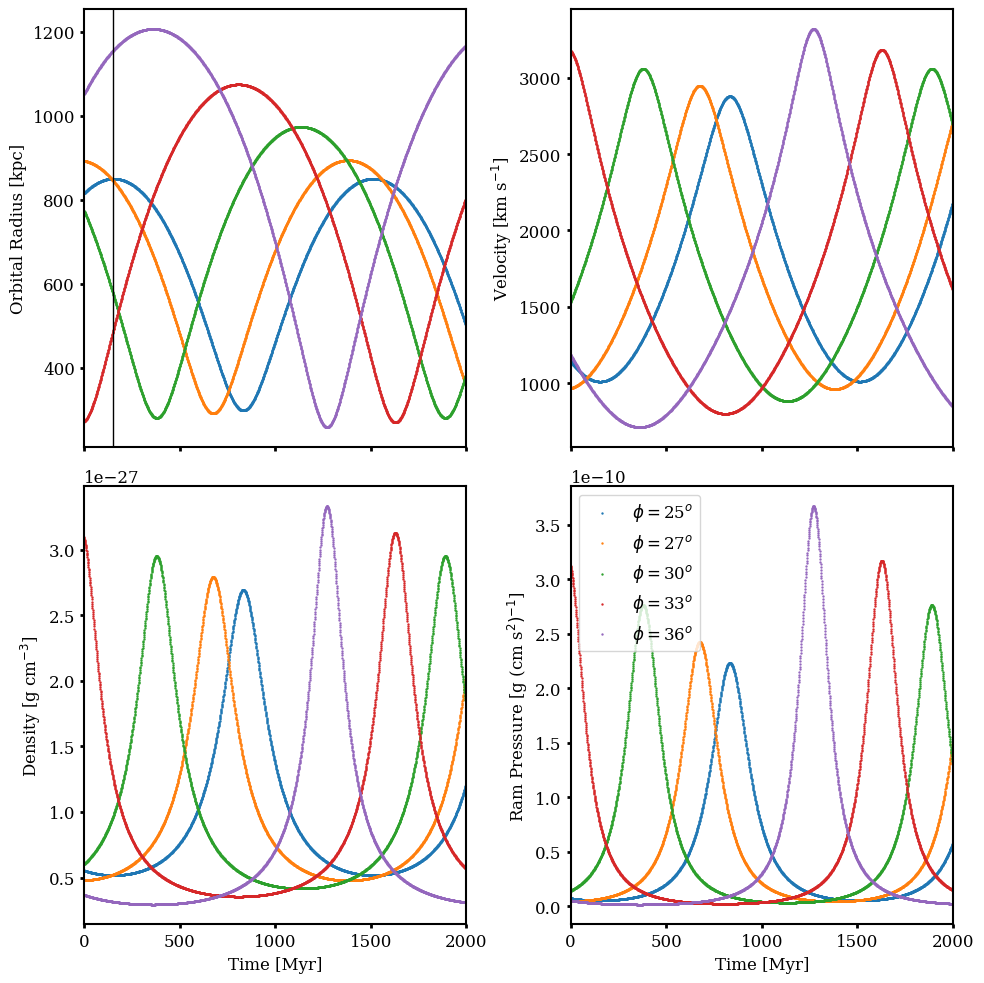

In [29]:
r = np.sqrt(np.sum(qs**2, axis=0))
v_tot = np.sqrt(np.sum(ps**2, axis=0)).to(u.km / u.s)

density = fit(r.value) * (u.g / u.cm**3)

rpp = (density * v_tot ** 2).to(u.g / u.cm / u.s**2)

i0 = 30

t0 = 0
period = 2000

folded_time = (ts.value + t0) #% period


fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True)

for i, set in enumerate(sets):
    time, q, p = set
    r = np.sqrt(np.sum(q**2, axis=0))
    v_tot = np.sqrt(np.sum(p**2, axis=0)).to(u.km / u.s)

    density = fit(r.value) * (u.g / u.cm**3)

    rpp = (density * v_tot ** 2).to(u.g / u.cm / u.s**2)

    folded_time = (time + t0) #% period

    ax[0][0].scatter(folded_time, r, s=0.5)
    ax[0][1].scatter(folded_time, v_tot, s=0.5)

    ax[1][0].scatter(folded_time, density, s=0.5)
    ax[1][1].scatter(folded_time, rpp, s=0.5, label=f'$\phi = ${angles[i]}$^o$')


ax[0][0].set_ylabel("Orbital Radius [kpc]")
ax[0][1].set_ylabel("Velocity [km s$^{-1}$]")

ax[1][0].set_ylabel("Density [g cm$^{-3}$]")

ax[1][1].set_ylabel("Ram Pressure [g (cm s$^{2})^{-1}$]")

ax[0][0].axvline(ts[i0].value)

for axis in ax[1]:
    axis.set_xlabel("Time [Myr]")

for axis in ax.flatten():
    axis.set_xlim(0, period)

plt.legend()
plt.tight_layout()
plt.savefig("Coma Cluster Orbits")

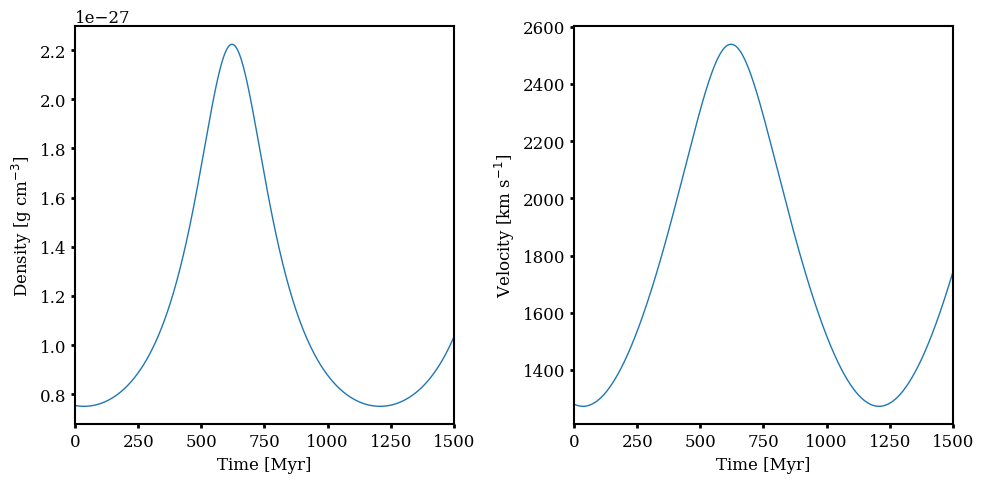

In [10]:
# dw_angle = 12

# time, q, p = gen_coma_orbit(dw_angle, i0=770)
# print(time.shape, q.shape, p.shape)
# r = np.sqrt(np.sum(q**2, axis=0))
# v_tot = np.sqrt(np.sum(p**2, axis=0)).to(u.km / u.s)

# density = fit(r.value) * (u.g / u.cm**3)



# time_ts = time[i0:].cgs.value
# time_ts -= time_ts[0]
# rho_ts = density[i0:].cgs.value

# temp_ts = np.array([1e7 for i in range(len(time_ts))])


# vx_ts = np.zeros(len(time_ts))
# vy_ts  = (v_tot[i0:] * np.cos(np.deg2rad(dw_angle))).cgs.value
# vz_ts = (v_tot[i0:] * np.sin(np.deg2rad(dw_angle))).cgs.value



# np.savetxt("ICMinflow_data.in", 
#           np.column_stack([time_ts, rho_ts,temp_ts, 
#                            vx_ts, vy_ts, vz_ts]),
#           fmt='%.10e',delimiter="  ",header='time    Density         Temp    Velocity (x,y,z) ')



t = Table.read("ICMinflow_data.in", format="ascii")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot((t["col1"] * u.s).to(u.Myr), t["col2"])
ax[0].set(xlim=(0, 1500), xlabel="Time [Myr]", ylabel="Density [g cm$^{-3}$]")

velocity = np.sqrt(t["col4"]**2 + t["col5"]**2 + t["col6"]**2)

ax[1].plot(t["col1"] * u.s.to(u.Myr), velocity * (u.cm / u.s).to(u.km/u.s))
ax[1].set_xlim(0, 1500)
ax[1].set(xlim=(0, 1500), xlabel="Time [Myr]", ylabel="Velocity [km s$^{-1}$]")

plt.tight_layout()
plt.show()

(0.0, 2500.0)

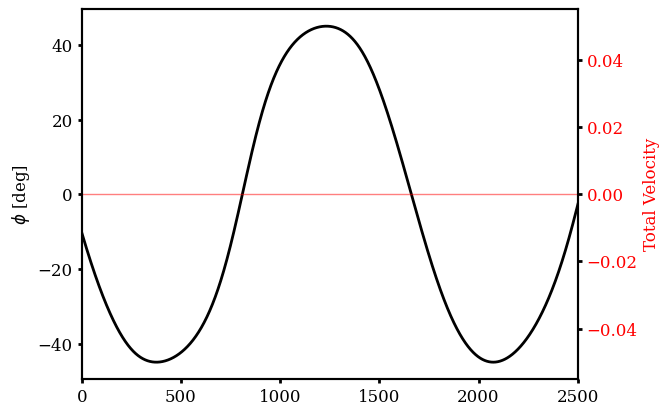

In [31]:

fig, ax1 = plt.subplots()


ax1.plot(time, np.rad2deg(np.arctan(p[0] / v_tot)), color="black", lw=2, zorder=5)

ax1.set_ylabel("$\phi$ [deg]")

ax2 = ax1.twinx()
ax2.plot(time_ts, vx_ts, color="red", alpha=0.5)
ax2.set_ylabel('Total Velocity', color="Red")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="red")
plt.xlim(0, 2500)

# An Alternative Way to Determine the Orbit

Following the Wetzel paper (and Zhu 2023), we adopt a similar methodology.



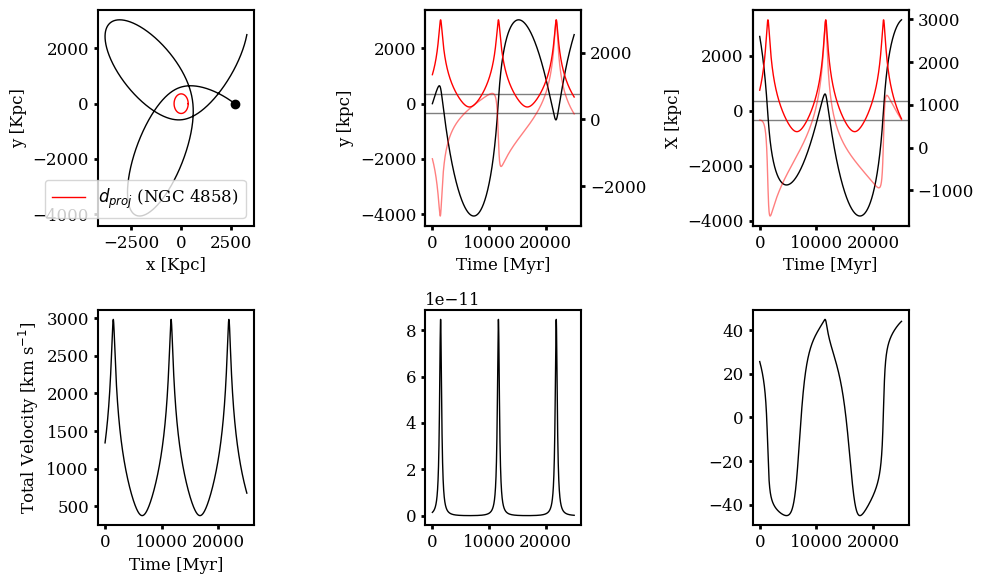

In [13]:

coma_mass = 0.95e15 * u.Msun
concentration = 9

coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                        c=concentration, 
                                        units=galactic)



v_200 = np.sqrt(c.G * coma_mass / (1.99 * u.Mpc)).to(u.km / u.s)


pos = [2.7, 0, 0] * u.Mpc
vel = [-0.822, 0.45, 0] * v_200


w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

n_steps, dt = 5000, 5 * u.Myr
orbit = gp.Hamiltonian(coma_pot).integrate_orbit(w0, dt=dt, n_steps=n_steps)

ell = grp.ellipse_coords(0, 0, 355, 355, 0)

x,y,z = orbit.pos.xyz
r = np.sqrt(x**2 + y**2 + z**2)

density = fit(r.value) * (u.g / u.cm**3)

vx, vy, vz = orbit.vel.d_xyz.to(u.km / u.s)

vtot = np.sqrt(vx**2 + vy**2 + vz**2)

dw_angle = np.rad2deg(np.arctan(vy / vtot))

rpp = (density * vtot ** 2).to(u.g / u.cm / u.s**2)

tlim = (0, 10000)


fig, ax = plt.subplots(2, 3, figsize=(10, 6), sharex=False)

ax[0][0].plot(x, y, color="black")
ax[0][0].scatter(x[0], y[0], color="black")
ax[0][0].set(xlabel="x [Kpc]", ylabel="y [Kpc]")
ax[0][0].plot(ell[0], ell[1], color="red", label="$d_{proj}$ (NGC 4858)")

ax[0][0].legend(loc="lower right", fontsize=12)

ax[0][1].plot(orbit.t, y, color="black")
ax[0][1].axhline(-355, color="black", alpha=0.5)
ax[0][1].axhline(355, color="black", alpha=0.5)

ax[0][1].set(xlabel="Time [Myr]", ylabel="y [kpc]", )

vtwin = ax[0][1].twinx()
vtwin.plot(orbit.t, vx, color="red", alpha=0.5)
vtwin.plot(orbit.t, vtot, color="red")


ax[0][2].plot(orbit.t, x, color="black")
ax[0][2].axhline(-355, color="black", alpha=0.5)
ax[0][2].axhline(355, color="black", alpha=0.5)

ax[0][2].set(xlabel="Time [Myr]", ylabel="X [kpc]", )

vtwin = ax[0][2].twinx()
vtwin.plot(orbit.t, vy, color="red", alpha=0.5)
vtwin.plot(orbit.t, vtot, color="red")


ax[1][0].plot(orbit.t, vtot, color="black")
ax[1][0].set(xlabel="Time [Myr]", ylabel="Total Velocity [km s$^{-1}$]")


ax[1][1].plot(orbit.t, rpp, color="black")

ax[1][2].plot(orbit.t, dw_angle, color="black")

plt.tight_layout()

#plt.subplots_adjust(wspace=0.5)
plt.show()

In [14]:
def PE(R):
    return coma_pot.energy([0, R.to(u.kpc).value, 0] * u.kpc)[0]
    # return -(c.G * menc / R).to(u.km **2 / u.s**2)

R_vir = 2700 * u.kpc
coma_pot = gp.NFWPotential.from_M200_c(M200=coma_mass, 
                                        c=concentration, 
                                        units=galactic)


pot_diff = PE(R_vir) - PE(355 * u.kpc)
v_355kpc = np.sqrt(2 * pot_diff).to(u.km / u.s).value


v_rad = (2420 * u.km / u.s).value
print(f"Vtot: {v_355kpc} km/s")
print(f"Vrad: {v_rad} km/s")


v_pos = np.sqrt(v_355kpc**2 - v_rad**2)

print(f"Vrad: {v_rad} km/s")
print(f"Vpos: {v_pos} km/s")

wind_inc = int(np.rad2deg(np.arccos(v_rad / v_355kpc)))

dw_angle = 90 - 38 - wind_inc

print(wind_inc, dw_angle)

Vtot: 3132.6301838291456 km/s
Vrad: 2420.0 km/s
Vrad: 2420.0 km/s
Vpos: 1989.21388207438 km/s
39 13


2420.0 1989.21388207438 3132.6301838291456
0.6880059230666747


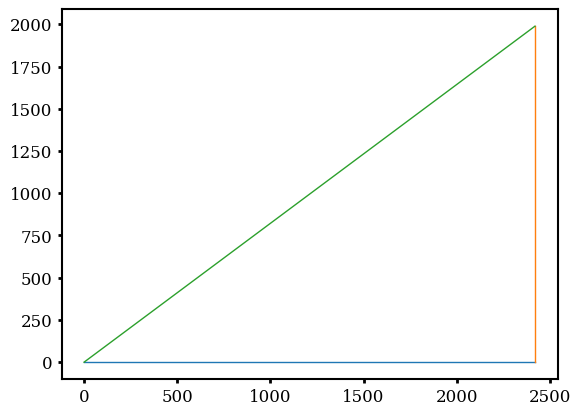

In [15]:
print(v_rad, v_pos, v_355kpc)

wind_inc = np.arccos(v_rad / v_355kpc)

print(wind_inc)

plt.figure()


plt.plot([0,v_rad], [0, 0])
plt.plot([v_rad, v_rad], [0, v_pos])
plt.plot([0, v_355kpc * np.cos(wind_inc)], [0, v_355kpc * np.sin(wind_inc)])